## Autoencoder Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

In [2]:
#import data
XL=pd.read_csv('9_510_L_resample_95_5.csv')
XU_train=pd.read_csv('9_510_U_resample_95_5.csv')# No resampling done in the unlabeled set, It just denotes the pair of L and U


In [3]:
from keras.layers import Input, Dense
from keras.models import Model
import keras.backend as K
import tensorflow as tf
from tensorflow.keras import regularizers
from keras.models import load_model
import keras
from keras.layers import Dropout
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.optimizers import Adagrad
from keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


In [4]:
yL_train=XL.iloc[:,-1]
XL_train=XL.iloc[:,:-1]

In [5]:
yL_train=pd.get_dummies(yL_train)#One-hot_encoding

# Split into train,test and val

#randomly split into train(80%) and val(20%)
XL_train,XL_val,yL_train,yL_val=train_test_split(XL_train,yL_train,random_state=0,test_size=0.2)

#randomly split val into val(10%) and test(10%)
XL_val,XL_test,yL_val,yL_test=train_test_split(XL_val,yL_val,random_state=0,test_size=0.5)

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

#scaling and normalization
scaler=StandardScaler()
XU_train=scaler.fit_transform(XU_train)
XL_train=scaler.fit_transform(XL_train)
XL_val=scaler.transform(XL_val)
XL_test=scaler.transform(XL_test)


In [7]:
from keras_sequential_ascii import keras2ascii
from tensorflow.keras import regularizers
from keras.models import Sequential
from keras import backend as K

In [8]:
'''
Function AE
Inputs: numpy array X, list layers,list activations,int n_epochs

layers is a list of no. of hidden nodes in each hidden layer
activations is a list of activations used in each encoding layer

trains each autoencoder layer and outputs all the encoder-layer models.

Output: a list of keras models

'''
def AE(X,layers,activations,n_epochs):
    layers.insert(0,len(X[0]))
    
    ec=[]
    for i in range(len(layers)-1):
        encoding_dim = layers[i+1]

        # this is our input placeholder
        input_ = Input(shape=(layers[i],))

        # "encoded" is the encoded representation of the input
        encoded = Dense(encoding_dim, activation=activations[i],bias_initializer='random_normal',kernel_initializer='he_uniform',name='encoder'+str(i+1))(input_)
        
        # "decoded" is the lossy reconstruction of the input
        decoded = Dense(layers[i],activation=None,name='decoder'+str(i+1))(encoded)

        # this model maps an input to its reconstruction
        autoencoder = Model(input_, decoded)

        # this model maps an input to its encoded representation
        encoder = Model(input_, encoded)

        # create a placeholder for an encoded (32-dimensional) input
        encoded_input = Input(shape=(encoding_dim,))

        #compile the autoencoder model
        autoencoder.compile(optimizer=RMSprop(learning_rate=0.001,clipnorm=0.1), loss='mse')
        
        print('Training Layer ' + str(i+1)+' : ')
        
        autoencoder.fit(X,X,
                epochs=n_epochs,
                batch_size=256,
                shuffle=True,
                validation_data=(X,X))
        ec.append(encoder)
        X=encoder.predict(X)
    print('All Layers Done!')    
    return ec       

In [9]:
#Train The Stacked Autoencoder
layers = [100,200,400,50]
activations=['relu','relu','relu','relu']
traint0=time.time()
stacked_layers=AE(XU_train,layers,activations,10)

Training Layer 1 : 
Train on 384366 samples, validate on 384366 samples
Epoch 1/10
384366/384366 [==============================] - 6s 15us/step - loss: 0.0684 - val_loss: 0.0095
Epoch 2/10
384366/384366 [==============================] - 6s 15us/step - loss: 0.0069 - val_loss: 0.0045
Epoch 3/10
384366/384366 [==============================] - 6s 15us/step - loss: 0.0044 - val_loss: 0.0031
Epoch 4/10
384366/384366 [==============================] - 6s 15us/step - loss: 0.0035 - val_loss: 0.0032
Epoch 5/10
384366/384366 [==============================] - 6s 15us/step - loss: 0.0031 - val_loss: 0.0023
Epoch 6/10
384366/384366 [==============================] - 5s 14us/step - loss: 0.0028 - val_loss: 0.0029
Epoch 7/10
384366/384366 [==============================] - 5s 14us/step - loss: 0.0026 - val_loss: 0.0016
Epoch 8/10
384366/384366 [==============================] - 5s 14us/step - loss: 0.0024 - val_loss: 0.0020
Epoch 9/10
384366/384366 [==============================] - 5s 14us/step

In [10]:
#add layers to a sequential model
model=Sequential()
for i in stacked_layers:
    model.add(i)

#softmax output layer
model.add(Dense(len(yL_train.columns),activation='softmax'))

In [11]:
model.compile(optimizer=RMSprop(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [12]:
#fine tune model runs for no. of epochs set below
history=model.fit(XL_train,yL_train,
                epochs=750,
                batch_size=256,
                shuffle=True,
                validation_data=(XL_val, yL_val))
traint1=time.time()

Train on 96292 samples, validate on 12036 samples
Epoch 1/750
96292/96292 [==============================] - 2s 21us/step - loss: 2.6894 - accuracy: 0.2409 - val_loss: 2.2164 - val_accuracy: 0.3676
Epoch 2/750
96292/96292 [==============================] - 2s 20us/step - loss: 2.0171 - accuracy: 0.4117 - val_loss: 1.8806 - val_accuracy: 0.4521
Epoch 3/750
96292/96292 [==============================] - 2s 20us/step - loss: 1.7729 - accuracy: 0.4857 - val_loss: 1.7039 - val_accuracy: 0.5020
Epoch 4/750
96292/96292 [==============================] - 2s 20us/step - loss: 1.6203 - accuracy: 0.5282 - val_loss: 1.5878 - val_accuracy: 0.5400
Epoch 5/750
96292/96292 [==============================] - 2s 20us/step - loss: 1.5070 - accuracy: 0.5562 - val_loss: 1.4967 - val_accuracy: 0.5543
Epoch 6/750
96292/96292 [==============================] - 2s 20us/step - loss: 1.4151 - accuracy: 0.5796 - val_loss: 1.4266 - val_accuracy: 0.5752
Epoch 7/750
96292/96292 [==============================] - 2s 

In [13]:
print("Train_time: "+str(traint1-traint0))

Train_time: 1776.4297544956207


In [14]:
test0=time.time()
print(model.evaluate(XL_test,yL_test))
test1=time.time()
print("Test_time: "+str(test1-test0))

12037/12037 [==============================] - 0s 23us/step
[0.36441210355568104, 0.9306305646896362]
Test_time: 0.28174805641174316


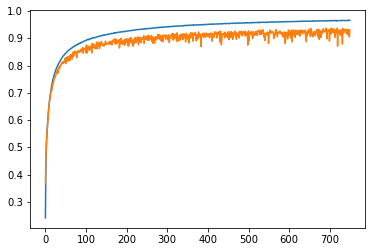

In [15]:
#Visualise convergence with no. of epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [17]:
y_pred=model.predict(XL_test)
y_pred1=y_pred.argmax(axis=1)
y_pred1=np.append(y_pred1,np.arange(24))
y_pred1=pd.get_dummies(y_pred1,columns=yL_train.columns)
y_pred1.columns=yL_test.columns
y_pred1=y_pred1.iloc[:-24]

In [18]:
yL_test.sum()

AMAZON            500
APPLE             474
APPLE_ITUNES      515
CLOUDFLARE        461
CONTENT_FLASH     494
DROPBOX           487
EBAY              508
FACEBOOK          473
GMAIL             501
GOOGLE            550
HTTP              491
HTTP_CONNECT      490
HTTP_PROXY        533
MICROSOFT         497
MSN               497
OFFICE_365        522
SKYPE             491
SSL               517
TWITTER           509
WHATSAPP          506
WIKIPEDIA         511
WINDOWS_UPDATE    502
YAHOO             515
YOUTUBE           493
dtype: int64

In [19]:
y_test1 = yL_test.columns[np.where(yL_test!=0)[1]]

In [20]:
y_pred1=y_pred1.columns[np.where(y_pred1!=0)[1]]
cm=confusion_matrix(y_test1,y_pred1,labels=yL_test.columns)
cm_pc=pd.DataFrame((cm.T/np.sum(cm,axis=1)).T,columns=yL_test.columns,index=yL_test.columns)
cm_pc=cm_pc.replace(np.nan,0)

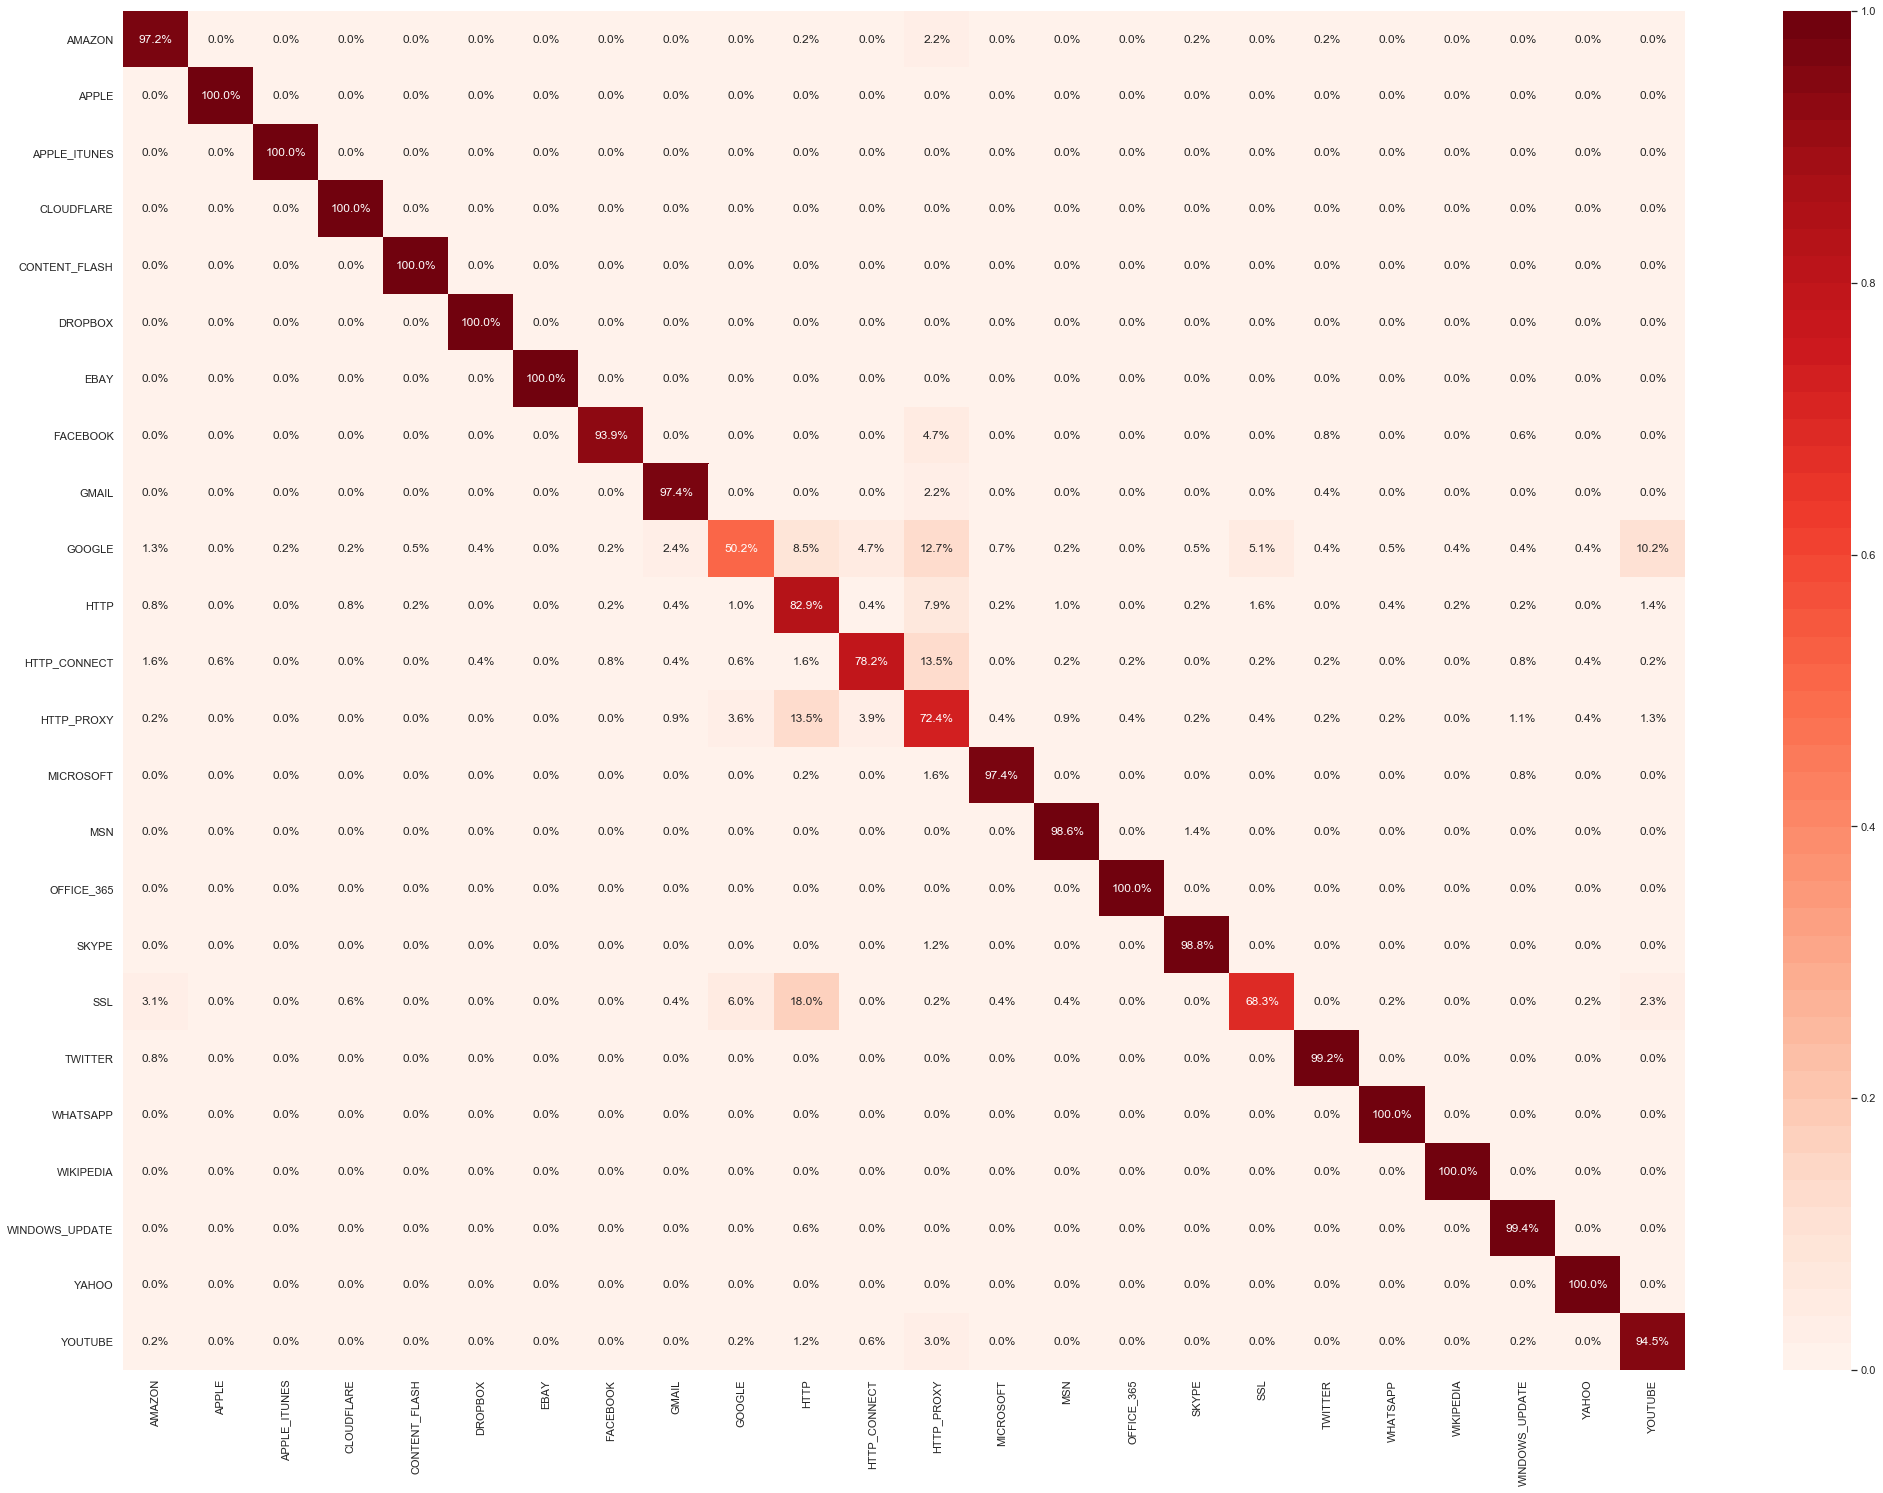

In [28]:
# Plot confusion matrix
plt.figure(figsize=(35,25))
df_cm=pd.DataFrame(cm,columns=yL_test.columns,index=yL_test.columns)
sns.set(font_scale=1.0)
sns.heatmap(cm_pc, annot=True,fmt='.1%',cmap=sns.color_palette("Reds",50)) # font size
plt.show()

In [29]:
print('Test Accuracy : '+str(accuracy_score(y_test1, y_pred1)))

Test Accuracy : 0.9258951566004818


In [30]:
print('weighted F1 Score : ' + str(f1_score(y_pred1,y_test1,average = 'weighted')))
print('Macro F1 Score : ' + str(f1_score(y_pred1,y_test1,average = 'macro')))
print('Micro F1 Score : ' + str(f1_score(y_pred1,y_test1,average = 'micro')))
print('F1 Scores : ' )
pd.DataFrame(f1_score(y_pred1,y_test1,labels=yL_test.columns,average = None),columns=['F1-score'],index=yL_test.columns)

weighted F1 Score : 0.9273424425245091
Macro F1 Score : 0.9265045586908415
Micro F1 Score : 0.9258951566004818
F1 Scores : 


,F1-score
AMAZON,0.946446
APPLE,0.996845
APPLE_ITUNES,0.999030
CLOUDFLARE,0.991398
CONTENT_FLASH,0.995968
DROPBOX,0.995910
EBAY,1.000000
FACEBOOK,0.962080
GMAIL,0.963475
GOOGLE,0.623729


In [31]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [32]:
print('Macro Presicion : '+str(precision_score(y_test1, y_pred1,average="macro")))
print('Micro Presicion : '+str(precision_score(y_test1, y_pred1,average="micro")))
print('Weighted Presicion : '+str(precision_score(y_test1, y_pred1,average="weighted")))
print('Precision Scores : ' )
pd.DataFrame(precision_score(y_pred1,y_test1,labels=yL_test.columns,average = None),columns=['Precision-score'],index=yL_test.columns)

Macro Presicion : 0.9311481066645017
Micro Presicion : 0.9258951566004818
Weighted Presicion : 0.9299448808565974
Precision Scores : 


,Precision-score
AMAZON,0.972000
APPLE,1.000000
APPLE_ITUNES,1.000000
CLOUDFLARE,1.000000
CONTENT_FLASH,1.000000
DROPBOX,1.000000
EBAY,1.000000
FACEBOOK,0.938689
GMAIL,0.974052
GOOGLE,0.501818


In [33]:
print('Macro Recall : '+str(recall_score(y_test1, y_pred1,average="macro")))
print('Micro Recall : '+str(recall_score(y_test1, y_pred1,average="micro")))
print('Weighted Recall : '+str(recall_score(y_test1, y_pred1,average="weighted")))
print('Recall Scores : ' )
pd.DataFrame(recall_score(y_pred1,y_test1,labels=yL_test.columns,average = None),columns=['recall-score'],index=yL_test.columns)

Macro Recall : 0.9284599025639003
Micro Recall : 0.9258951566004818
Weighted Recall : 0.9258951566004818
Recall Scores : 


,recall-score
AMAZON,0.922201
APPLE,0.993711
APPLE_ITUNES,0.998062
CLOUDFLARE,0.982942
CONTENT_FLASH,0.991968
DROPBOX,0.991853
EBAY,1.000000
FACEBOOK,0.986667
GMAIL,0.953125
GOOGLE,0.823881


#### Confusion Matrix with 10 chosen well-known classes

Classes : AMAZON, FACEBOOK, GMAIL, GOOGLE, HTTP, OFFICE_365, SKYPE, TWITTER, WHATSAPP, YOUTUBE

In [21]:
from sklearn.metrics import confusion_matrix
apps=['AMAZON','FACEBOOK','GMAIL','GOOGLE','HTTP','OFFICE_365','SKYPE','TWITTER','WHATSAPP','YOUTUBE']#reporting for these well-known Apps
y_test1[y_test1.isin(apps)]
cm=confusion_matrix(y_test1[y_test1.isin(apps)],y_pred1[y_test1.isin(apps)],labels=y_test1[y_test1.isin(apps)].unique())

In [22]:
cm_pc=pd.DataFrame((cm.T/np.sum(cm,axis=1)).T,columns=y_test1[y_test1.isin(apps)].unique(),index=y_test1[y_test1.isin(apps)].unique())
cm_pc=cm_pc.replace(np.nan,0)

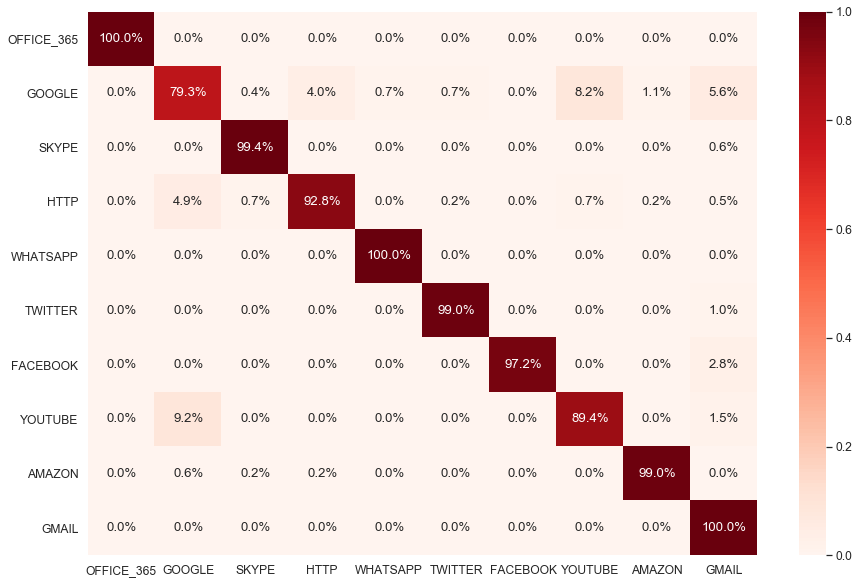

In [23]:
plt.figure(figsize=(15,10))
df_cm=pd.DataFrame(cm,columns=y_test1[y_test1.isin(apps)].unique(),index=y_test1[y_test1.isin(apps)].unique())
sns.set(font_scale=1.1)
sns.heatmap(cm_pc, annot=True,fmt='.1%',cmap=sns.color_palette("Reds",150)) # font size
plt.show()